**This is the notebook for the practical part of lab 1.** 

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api
import re
import copy

import data_loading_code as dlc

## Load data
### tfidf
small dataset

In [2]:
# get and pre-process data 
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)

data.columns = ['Sentence', 'Class']
data['index'] = data.index # add new column index
columns = ['index', 'Class', 'Sentence']
data = dlc.preprocess_pandas(data, columns) # pre-process

# split the data into training, validation, and test splits
# first get 50% for training
X_train, X_rest, y_train, y_rest = train_test_split(
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=0,
    shuffle=True
)

# split rest to get 50/20/30 split
X_val, X_test, y_val, y_test = train_test_split(
    X_rest,
    y_rest,
    test_size=0.6,  # 60% of 50% = 30% test
    random_state=0,
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
X_train_vec = word_vectorizer.fit_transform(X_train).todense() # transform texts to sparse matrix and then to dense matrix for Pytorch
X_val_vec = word_vectorizer.transform(X_val).todense()
X_test_vec = word_vectorizer.transform(X_test).todense()

# convert to tensors
train_x_tensor = torch.from_numpy(np.array(X_train_vec)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)

val_x_tensor = torch.from_numpy(np.array(X_val_vec)).type(torch.FloatTensor)
val_y_tensor = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)

test_x_tensor = torch.from_numpy(np.array(X_test_vec)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)

# build datasets and DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

large dataset

In [3]:
data_large = pd.read_csv("amazon_cells_labelled_LARGE_25K.txt", delimiter='\t', header=None)
data_large.columns = ['Sentence', 'Class']
data_large['index'] = data_large.index
data_large = dlc.preprocess_pandas(data_large, columns)

X_train_l, X_rest_l, y_train_l, y_rest_l = train_test_split(
    data_large['Sentence'].values.astype('U'),
    data_large['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=42,
    shuffle=True
)

X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(
    X_rest_l, y_rest_l, test_size=0.6, random_state=42, shuffle=True
)

vectorizer_large = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
X_train_l_vec = vectorizer_large.fit_transform(X_train_l).todense()
X_val_l_vec = vectorizer_large.transform(X_val_l).todense()
X_test_l_vec = vectorizer_large.transform(X_test_l).todense()

train_x_tensor_l = torch.from_numpy(np.array(X_train_l_vec)).type(torch.FloatTensor)
train_y_tensor_l = torch.from_numpy(np.array(y_train_l)).type(torch.FloatTensor)
val_x_tensor_l = torch.from_numpy(np.array(X_val_l_vec)).type(torch.FloatTensor)
val_y_tensor_l = torch.from_numpy(np.array(y_val_l)).type(torch.FloatTensor)
test_x_tensor_l = torch.from_numpy(np.array(X_test_l_vec)).type(torch.FloatTensor)
test_y_tensor_l = torch.from_numpy(np.array(y_test_l)).type(torch.FloatTensor)

train_loader_large = DataLoader(TensorDataset(train_x_tensor_l, train_y_tensor_l), batch_size=32, shuffle=True)
val_loader_large = DataLoader(TensorDataset(val_x_tensor_l, val_y_tensor_l), batch_size=32, shuffle=False)
test_loader_large = DataLoader(TensorDataset(test_x_tensor_l, test_y_tensor_l), batch_size=32, shuffle=False)

## Word2Vec

In [4]:
# # load pretrained word2vec model
# word_vectors = api.load("glove-wiki-gigaword-100")

# ANN Classifier

In [5]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [6]:
class SimpleANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(SimpleANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [7]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_loss_array = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            labels = labels.float().unsqueeze(1)  # [batch, 1] for BCELoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss / len(train_loader)
        train_loss_array.append(training_loss)

        val_loss, val_acc, _, _ = test_model(loader=val_loader, model=model, criterion=criterion)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model.name)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print(f"Best validation accuracy: {best_accuracy}%")
    return model


def test_model(loader, model=None, criterion=None, input_size=None):
    if model is None:
        model = ANNClassifier(input_size)
        model.load_state_dict(torch.load('amazonclass.pth'))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.squeeze().tolist())
            all_preds.extend(predicted.squeeze().tolist())

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return loss, accuracy, np.array(all_labels), np.array(all_preds)

In [8]:
def plot_confusion_matrix(all_labels=None, all_predictions=None, class_labels=None):
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
        return

    if class_labels is None:
        class_labels = ["Negative (0)", "Positive (1)"]  # Default

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)
    # print("Confusion Matrix:\n", cm)

    # Plot it with descriptive labels
    fig, ax = plt.subplots(figsize=(6, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Train simple ANN Classifier on small dataset

In [9]:
model_name ='amazonclasssimple'
input_size = train_x_tensor.shape[1]
model = SimpleANNClassifier(input_size, model_name)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=250)

Epoch 1/250, Train Loss: 0.7368, Val Loss: 0.6907, Train Acc: 49.80%, Val Acc: 53.00%
Epoch 2/250, Train Loss: 0.7181, Val Loss: 0.6845, Train Acc: 55.80%, Val Acc: 53.00%
Epoch 3/250, Train Loss: 0.6899, Val Loss: 0.6668, Train Acc: 54.40%, Val Acc: 56.50%
Epoch 4/250, Train Loss: 0.6746, Val Loss: 0.6589, Train Acc: 57.60%, Val Acc: 59.50%
Epoch 5/250, Train Loss: 0.6405, Val Loss: 0.6491, Train Acc: 61.40%, Val Acc: 62.50%
Epoch 6/250, Train Loss: 0.6196, Val Loss: 0.6423, Train Acc: 64.60%, Val Acc: 63.00%
Epoch 7/250, Train Loss: 0.5996, Val Loss: 0.6375, Train Acc: 66.80%, Val Acc: 64.00%
Epoch 8/250, Train Loss: 0.5781, Val Loss: 0.6299, Train Acc: 69.40%, Val Acc: 65.50%
Epoch 9/250, Train Loss: 0.5669, Val Loss: 0.6224, Train Acc: 67.20%, Val Acc: 65.50%
Epoch 10/250, Train Loss: 0.5463, Val Loss: 0.6198, Train Acc: 72.20%, Val Acc: 66.00%
Epoch 11/250, Train Loss: 0.5462, Val Loss: 0.6169, Train Acc: 70.80%, Val Acc: 68.00%
Epoch 12/250, Train Loss: 0.5415, Val Loss: 0.6130, 

Accuracy on testing dataset: 80.0%
F1-Score: 0.81


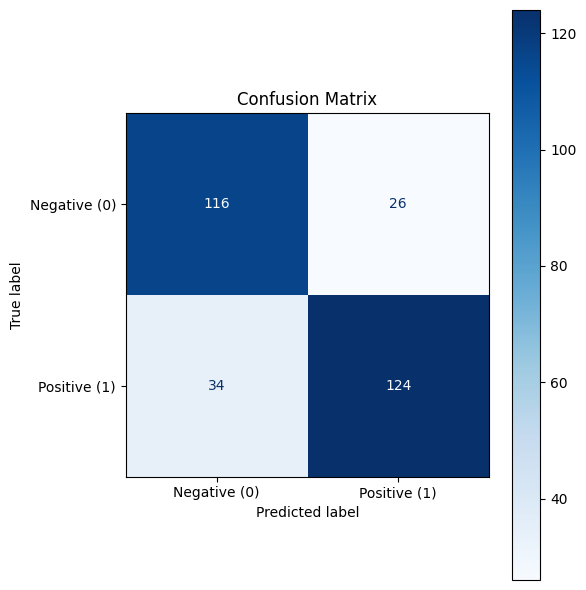

In [10]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

Train simple ANN Classifier on large dataset

In [11]:
model_name ='amazonclasssimplelarge'
input_size = train_x_tensor_l.shape[1]
model = SimpleANNClassifier(input_size, model_name)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.6125, Val Loss: 0.5133, Train Acc: 66.25%, Val Acc: 81.74%
Epoch 2/25, Train Loss: 0.5242, Val Loss: 0.4691, Train Acc: 76.62%, Val Acc: 84.90%
Epoch 3/25, Train Loss: 0.4733, Val Loss: 0.4389, Train Acc: 81.78%, Val Acc: 86.22%
Epoch 4/25, Train Loss: 0.4368, Val Loss: 0.4040, Train Acc: 83.97%, Val Acc: 87.66%
Epoch 5/25, Train Loss: 0.4057, Val Loss: 0.3805, Train Acc: 85.42%, Val Acc: 88.18%
Epoch 6/25, Train Loss: 0.3812, Val Loss: 0.3588, Train Acc: 86.73%, Val Acc: 88.68%
Epoch 7/25, Train Loss: 0.3560, Val Loss: 0.3414, Train Acc: 87.59%, Val Acc: 88.84%
Epoch 8/25, Train Loss: 0.3370, Val Loss: 0.3323, Train Acc: 88.04%, Val Acc: 88.24%
Epoch 9/25, Train Loss: 0.3245, Val Loss: 0.3139, Train Acc: 88.11%, Val Acc: 88.72%
Epoch 10/25, Train Loss: 0.3089, Val Loss: 0.3087, Train Acc: 88.87%, Val Acc: 88.80%
Epoch 11/25, Train Loss: 0.2945, Val Loss: 0.2985, Train Acc: 89.40%, Val Acc: 88.68%
Epoch 12/25, Train Loss: 0.2939, Val Loss: 0.2943, Train Acc: 8

Accuracy on testing dataset: 88.93333333333334%
F1-Score: 0.91


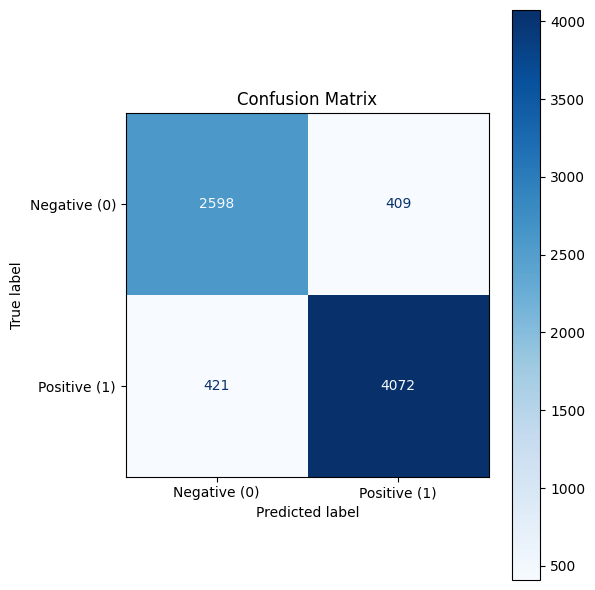

In [12]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

Train ANN Classifier on large dataset

In [13]:
model_name_l = 'amazonclasslarge'
input_size = train_x_tensor_l.shape[1]
model = ANNClassifier(input_size, model_name_l)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_large, val_loader_large, num_epochs=25)

Epoch 1/25, Train Loss: 0.6360, Val Loss: 0.5027, Train Acc: 69.53%, Val Acc: 85.32%
Epoch 2/25, Train Loss: 0.4856, Val Loss: 0.4418, Train Acc: 83.91%, Val Acc: 85.38%
Epoch 3/25, Train Loss: 0.3863, Val Loss: 0.3982, Train Acc: 90.21%, Val Acc: 85.12%
Epoch 4/25, Train Loss: 0.3194, Val Loss: 0.3679, Train Acc: 92.81%, Val Acc: 85.96%
Epoch 5/25, Train Loss: 0.2714, Val Loss: 0.3603, Train Acc: 94.30%, Val Acc: 85.62%
Epoch 6/25, Train Loss: 0.2404, Val Loss: 0.3689, Train Acc: 95.32%, Val Acc: 85.82%
Epoch 7/25, Train Loss: 0.2218, Val Loss: 0.3717, Train Acc: 95.29%, Val Acc: 85.80%
Epoch 8/25, Train Loss: 0.2012, Val Loss: 0.3940, Train Acc: 95.49%, Val Acc: 85.70%
Epoch 9/25, Train Loss: 0.1932, Val Loss: 0.4236, Train Acc: 95.50%, Val Acc: 85.72%
Epoch 10/25, Train Loss: 0.1837, Val Loss: 0.4233, Train Acc: 95.50%, Val Acc: 85.96%
Epoch 11/25, Train Loss: 0.1789, Val Loss: 0.4435, Train Acc: 95.46%, Val Acc: 85.48%
Epoch 12/25, Train Loss: 0.1779, Val Loss: 0.4456, Train Acc: 9

Accuracy on testing dataset: 86.45333333333333%
F1-Score: 0.89


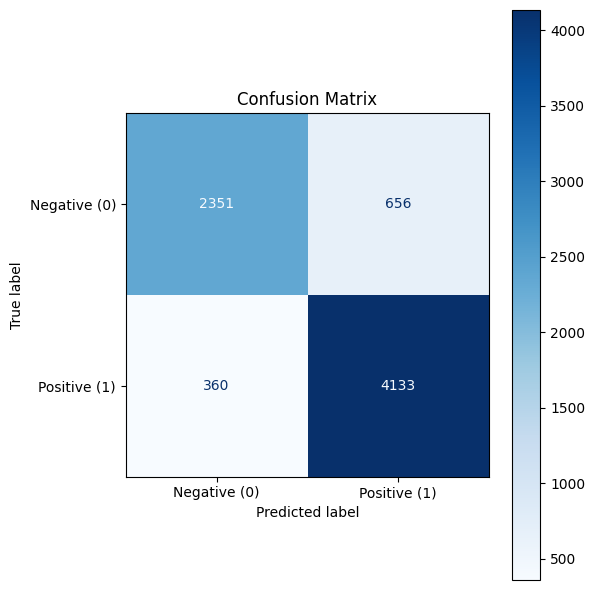

In [14]:
# Load best model
model = ANNClassifier(input_size, model_name_l)
model.load_state_dict(torch.load(model.name))

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_large, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)